# $D^0 \to K^0_Sπ^+π^-$ with Mixing

We will fit 

$$
D^0 \to K^0_S \pi^+\pi^-
$$

decays generated with the following intermediate resonances:
- $D^0 \to K^0_S \rho(770)$
- $D^0 \to K^{*-}\pi^+$

In addition we add mixing, meaning that $D^0$ oscillates to $\bar{D}^0$, which subsequently decays with a charged-conjugate decay model, depending on time:

$$
|\mathcal{A}(t)|^2 = \frac{1}{4}\left|\mathcal{A}_{D^0} + \frac{q}{p}\mathcal{A}_{\bar{D}^0}\right|^2 \psi_+(t) + 
                     \frac{1}{4}\left|\mathcal{A}_{D^0} - \frac{q}{p}\mathcal{A}_{\bar{D}^0}\right|^2 \psi_-(t) + 
                     2 \Re{\left((\mathcal{A}_{D^0} + \frac{q}{p}\mathcal{A}_{\bar{D}^0})(\mathcal{A}_{D^0} - \frac{q}{p}\mathcal{A}_{\bar{D}^0})^*\psi_i(t)\right)},
$$

with

$$
\begin{align*}
\psi_+(t) &= e^{ -(1+y)\frac{t}{\tau} }\\
\psi_-(t) &= e^{ -(1-y)\frac{t}{\tau} }\\
\psi_i(t) &= e^{ -(1+ix)\frac{t}{\tau} }\\
\end{align*}
$$

Import modules

In [1]:
# import NumPy
import numpy as np
# Import Tensorflow
import tensorflow as tf
# Import AmpliTF modules
import amplitf.interface as atfi
import amplitf.kinematics as atfk
import amplitf.dynamics as atfd
import amplitf.likelihood as atfl
import amplitf.mixing as atfm
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace
from amplitf.phasespace.decaytime_phasespace import DecayTimePhaseSpace
from amplitf.phasespace.combined_phasespace import CombinedPhaseSpace
#from amplitf.mixing import psip, psim, psii, mixing_density

# Import TFA modules
import tfa.toymc as tft
import tfa.plotting as tfp
import tfa.optimisation as tfo

# Import plotting module
import matplotlib.pyplot as plt

2025-09-13 08:12:27.675099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757743947.695519 3114268 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757743947.701835 3114268 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757743947.718267 3114268 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757743947.718287 3114268 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757743947.718290 3114268 computation_placer.cc:177] computation placer alr

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


I0000 00:00:1757743949.971395 3114268 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 35203 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


Set the number of events to generate and the number of normalisation point to calculate the integral of the likelihood

In [2]:
ntoys = 100000  # Number of points to generate
nnorm = 1000000  # Number of normalisation points

Now define the phase space

In [3]:
# Phase space
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)
tdz = atfi.const(1.)
tphsp = DecayTimePhaseSpace(tdz)
c_phsp = CombinedPhaseSpace(phsp,tphsp)

The mixing parameters

In [4]:
x_mix = atfi.const(0.)#atfi.const(0.004)
y_mix = atfi.const(0.0)#atfi.const(0.0064)
qop_mix = atfi.const(1)
phi_mix = atfi.const(0)
qoverp = atfi.complex( qop_mix * atfi.cos(phi_mix), 
                       qop_mix * atfi.sin(phi_mix) )

## Phasespace
Let's study the phasespace and the value of the functions on it

In [5]:
unfi_sample = c_phsp.unfiltered_sample(10000,1.0e-20)
comb_sample = c_phsp.filter(unfi_sample)

Plot the invariant masses and the decay time

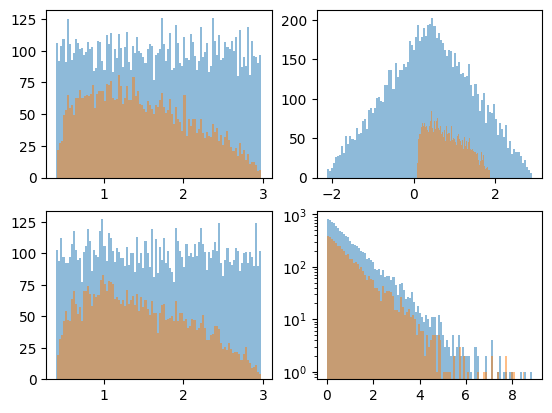

In [6]:
fig, ax = plt.subplots(2,2)
_ = ax[0][0].hist( np.array(c_phsp.phsp1.m2ab(c_phsp.data1(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[0][0].hist( np.array(c_phsp.phsp1.m2ab(c_phsp.data1(comb_sample)) ),bins=100, alpha=0.5)
_ = ax[1][0].hist( np.array(c_phsp.phsp1.m2bc(c_phsp.data1(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[1][0].hist( np.array(c_phsp.phsp1.m2bc(c_phsp.data1(comb_sample)) ),bins=100, alpha=0.5)
_ = ax[0][1].hist( np.array(c_phsp.phsp1.m2ac(c_phsp.data1(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[0][1].hist( np.array(c_phsp.phsp1.m2ac(c_phsp.data1(comb_sample)) ),bins=100, alpha=0.5)
_ = ax[1][1].hist( np.array(c_phsp.phsp2.t(c_phsp.data2(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[1][1].hist( np.array(c_phsp.phsp2.t(c_phsp.data2(comb_sample)) ),bins=100, alpha=0.5)
ax[1][1].set_yscale('log')

## Model
Below there is a function to define the model, allowing to switch on and off specific components.

In [7]:
from context import models
from models.d02kspipi import babar2008_model_amp
from models.helpers import decode_model, plot_data, plot_data_mix, plot_data_comparison_mix

In [8]:
import os
os.environ["TFAEX_ROOT"] = "../"

In [9]:
meta = atfi.const(lp.eta.mass/1000.)
metap = atfi.const(lp.etap_958.mass/1000.)
belle_model = decode_model('../../d02kspipi_toys/generator/inputs/belle_model.txt')

In [10]:
def babar_model_amp(x):
    return babar2008_model_amp(x, phsp,
        atfi.const(belle_model['rho770_Mass'][0]),
        atfi.const(belle_model['rho770_Width'][0]),
        atfi.const(belle_model['Kstar892_Mass'][0]),
        atfi.const(belle_model['Kstar892_Width'][0]),
        atfi.const(belle_model['Kstartwo1430_Mass'][0]),
        atfi.const(belle_model['Kstartwo1430_Width'][0]),
        atfi.const(belle_model['Kstar1410_Mass'][0]),
        atfi.const(belle_model['Kstar1410_Width'][0]),
        atfi.const(belle_model['Kstar1680_Mass'][0]),
        atfi.const(belle_model['Kstar1680_Width'][0]),
        atfi.const(belle_model['omega_Mass'][0]),
        atfi.const(belle_model['omega_Width'][0]),
        atfi.const(belle_model['ftwo1270_Mass'][0]),
        atfi.const(belle_model['ftwo1270_Width'][0]),
        atfi.const(belle_model['rho1450_Mass'][0]),
        atfi.const(belle_model['rho1450_Width'][0]),
        # LASS
        atfi.const(belle_model['LASS_a'][0]),
        atfi.const(belle_model['LASS_r'][0]),
        atfi.const(1.4617),
        atfi.const(0.2683),
        atfi.const(belle_model['LASS_R'][0]),
        atfi.const(belle_model['LASS_phi_R'][0]),
        atfi.const(belle_model['LASS_F'][0]),
        atfi.const(belle_model['LASS_phi_F'][0]),
        # K matrix model parameters
        atfi.const( [0.651, 1.2036, 1.55817, 1.21, 1.82206] ),
        atfi.const( [ [0.22889, -0.55377, 0, -0.39899, -0.34639],
                        [0.94128, 0.55095, 0, 0.39065, 0.31503],
                        [0.36856, 0.23888, 0.55639, 0.18340, 0.18681],
                        [0.33650, 0.40907, 0.85679, 0.19906, -0.00984],
                        [0.18171, -0.17558, -0.79658, -0.00355, 0.22358]] ),
        atfi.const(-3.92637),
        atfi.const([ [  0.23399,  0.15044, -0.20545,  0.32825,  0.35412],
                   [  0.15044, 0, 0, 0, 0],
                   [ -0.20545, 0, 0, 0, 0],
                   [  0.32825, 0, 0, 0, 0],
                   [  0.35412, 0, 0, 0, 0]]),
        atfi.stack([belle_model[f'Kmatrix_beta{i}_realpart'][0]+\
                    1.j*belle_model[f'Kmatrix_beta{i}_imaginarypart'][0] for i in range(1, 6)]),
        atfi.const(-0.070000000000000),
        atfi.stack([belle_model[f'Kmatrix_f_prod_1{i}_realpart'][0]+\
                    1.j*belle_model[f'Kmatrix_f_prod_1{i}_imaginarypart'][0] for i in range(1, 6)]),
        [[mpi,mpi], [mkz, mkz], [mpi], [meta, meta], [meta, metap]])

def Af(x, switches=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]):#15 * [1]):
    return babar_model_amp(x)(
        switches=switches,
        a1r=atfi.const(1.0), 
        a1i=atfi.const(0.0),
        a2r=atfi.const(belle_model['Kstar892minus_realpart'][0]),
        a2i=atfi.const(belle_model['Kstar892minus_imaginarypart'][0]),
        a3r=atfi.const(belle_model['Kstarzero1430minus_realpart'][0]),
        a3i=atfi.const(belle_model['Kstarzero1430minus_imaginarypart'][0]),
        a4r=atfi.const(belle_model['Kstartwo1430minus_realpart'][0]),
        a4i=atfi.const(belle_model['Kstartwo1430minus_imaginarypart'][0]),
        a5r=atfi.const(belle_model['Kstar1410minus_realpart'][0]),
        a5i=atfi.const(belle_model['Kstar1410minus_imaginarypart'][0]),
        a6r=atfi.const(belle_model['Kstar1680minus_realpart'][0]),
        a6i=atfi.const(belle_model['Kstar1680minus_imaginarypart'][0]),
        a7r=atfi.const(belle_model['Kstar892plus_realpart'][0]),
        a7i=atfi.const(belle_model['Kstar892plus_imaginarypart'][0]),
        a8r=atfi.const(belle_model['Kstarzero1430plus_realpart'][0]),
        a8i=atfi.const(belle_model['Kstarzero1430plus_imaginarypart'][0]),
        a9r=atfi.const(belle_model['Kstartwo1430plus_realpart'][0]),
        a9i=atfi.const(belle_model['Kstartwo1430plus_imaginarypart'][0]),
        a10r=atfi.const(belle_model['Kstar1410plus_realpart'][0]),
        a10i=atfi.const(belle_model['Kstar1410plus_imaginarypart'][0]),
        a11r=atfi.const(belle_model['Kstar1680plus_realpart'][0]),
        a11i=atfi.const(belle_model['Kstar1680plus_imaginarypart'][0]),
        a12r=atfi.const(belle_model['omega_realpart'][0]),
        a12i=atfi.const(belle_model['omega_imaginarypart'][0]),
        a13r=atfi.const(belle_model['ftwo1270_realpart'][0]),
        a13i=atfi.const(belle_model['ftwo1270_imaginarypart'][0]),
        a14r=atfi.const(belle_model['rho1450_realpart'][0]),
        a14i=atfi.const(belle_model['rho1450_imaginarypart'][0]),
    )

def Afbar(x):
    # the conjugate of the amplitude
    # is the same as the amplitude with the masses swapped
    return Af(x[:,::-1])

In [11]:
c_phsp.phsp2.t(c_phsp.data2(comb_sample))

<tf.Tensor: shape=(4759,), dtype=float64, numpy=
array([0.55387408, 0.21092159, 2.8767296 , ..., 0.31184576, 0.90943864,
       0.35588479])>

In [12]:
def model_mix(x):
    # Calculate the amplitudes
    ampl_dz = Af(c_phsp.data1(x))
    ampl_dzb = Afbar(c_phsp.data1(x))
    def _model(x_mix_par, y_mix_par, qoverp_re, qoverp_im):
        t = c_phsp.phsp2.t(c_phsp.data2(x))
        tep = atfm.psip(t, y_mix_par, atfi.const(1.0))
        tem = atfm.psim(t, y_mix_par, atfi.const(1.0))
        tei = atfm.psii(t, x_mix_par, atfi.const(1.0))
        # calculate the amplitude density
        dens = atfm.mixing_density(ampl_dz, ampl_dzb, atfi.complex(qoverp_re, qoverp_im), tep, tem, tei)
        return dens
    return _model

In [13]:
def toymc_model_mix(x):
    return model_mix(x)(
        x_mix_par=x_mix,
        y_mix_par=y_mix,
        qoverp_re=atfi.real(qoverp),
        qoverp_im=atfi.imaginary(qoverp)
        )

In [14]:
ntoys = 100000
toy_sample = tft.run_toymc(
    toymc_model_mix, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)

I0000 00:00:1757743959.680752 3114462 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x555a41e030d0


  Updating maximum: 1e-20 -> 6755.786120336623. Starting over.
  Chunk 1, size=5440, total length=5440
  Chunk 2, size=5510, total length=10950
  Chunk 3, size=5528, total length=16478
  Chunk 4, size=5477, total length=21955
  Chunk 5, size=5536, total length=27491
  Chunk 6, size=5586, total length=33077
  Chunk 7, size=5436, total length=38513
  Chunk 8, size=5568, total length=44081
  Chunk 9, size=5509, total length=49590
  Chunk 10, size=5563, total length=55153
  Chunk 11, size=5478, total length=60631
  Chunk 12, size=5559, total length=66190
  Chunk 13, size=5565, total length=71755
  Chunk 14, size=5362, total length=77117
  Chunk 15, size=5396, total length=82513
  Chunk 16, size=5389, total length=87902
  Chunk 17, size=5418, total length=93320
  Chunk 18, size=5440, total length=98760
  Chunk 19, size=5418, total length=104178


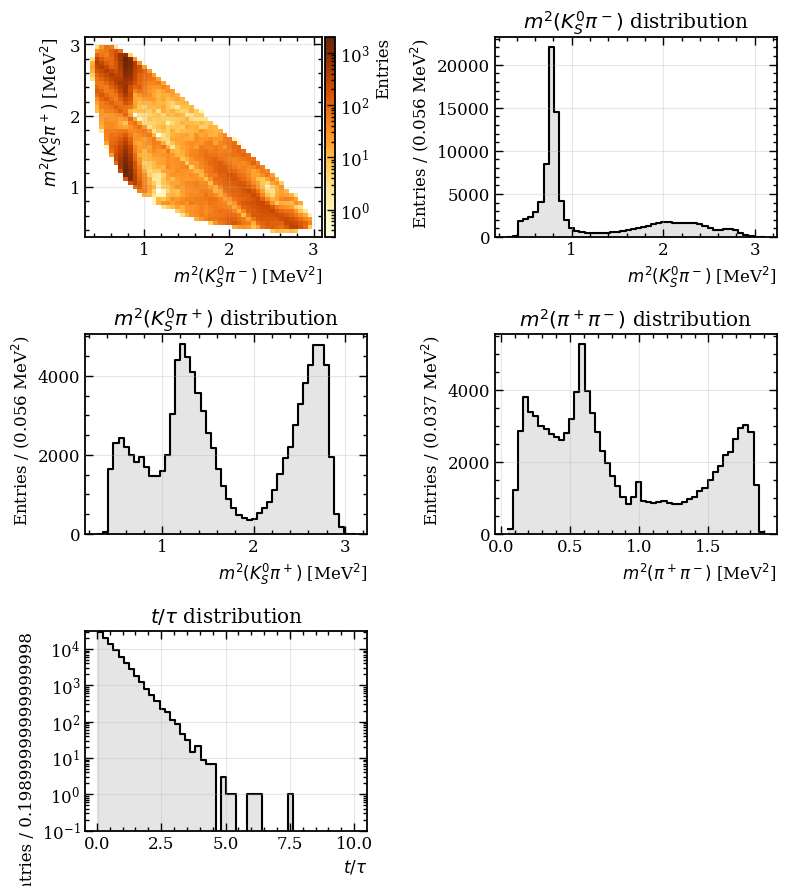

In [15]:
fig, ax= plot_data_mix(toy_sample, c_phsp)

  Updating maximum: 1e-20 -> 6883.518736235549. Starting over.
  Chunk 1, size=5381, total length=5381
  Chunk 2, size=5287, total length=10668
  Chunk 3, size=5409, total length=16077
  Chunk 4, size=5404, total length=21481
  Chunk 5, size=5327, total length=26808
  Chunk 6, size=5498, total length=32306
  Chunk 7, size=5454, total length=37760
  Chunk 8, size=5385, total length=43145
  Chunk 9, size=5451, total length=48596
  Chunk 10, size=5322, total length=53918
  Chunk 11, size=5356, total length=59274
  Chunk 12, size=5316, total length=64590
  Chunk 13, size=5473, total length=70063
  Chunk 14, size=5374, total length=75437
  Chunk 15, size=5367, total length=80804
  Chunk 16, size=5459, total length=86263
  Chunk 17, size=5409, total length=91672
  Chunk 18, size=5384, total length=97056
  Chunk 19, size=5429, total length=102485


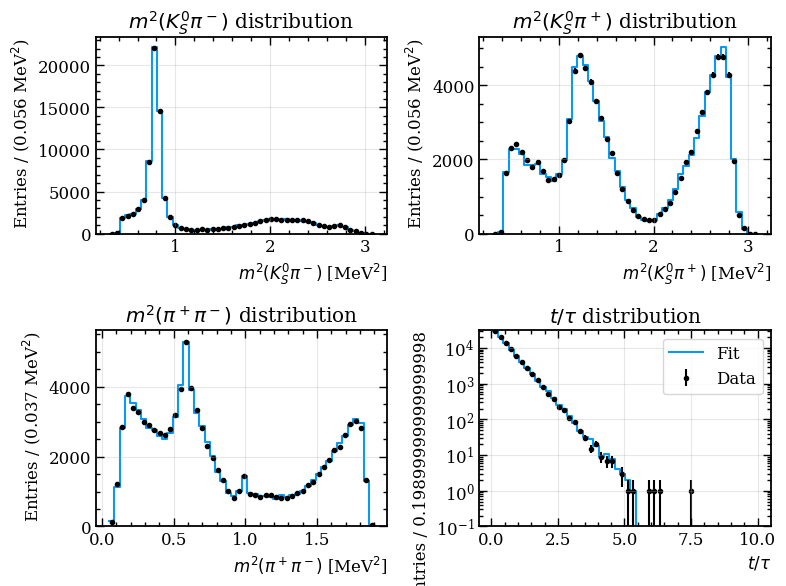

In [16]:
x_mix = atfi.const(0.004)
y_mix = atfi.const(0.0064)
qoverp = atfi.complex(atfi.const(1.0), atfi.const(0.0))
def toymc_model_mix(x):
    return model_mix(x)(
        x_mix_par=x_mix,
        y_mix_par=y_mix,
        qoverp_re=atfi.real(qoverp),
        qoverp_im=atfi.imaginary(qoverp)
        )
toy_sample_mix = tft.run_toymc(
    toymc_model_mix, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)
fig, ax = plot_data_comparison_mix([toy_sample,toy_sample_mix], c_phsp)

  Updating maximum: 1e-20 -> 6832.881866821827. Starting over.
  Chunk 1, size=5729, total length=5729
  Chunk 2, size=5682, total length=11411
  Chunk 3, size=5719, total length=17130
  Chunk 4, size=5699, total length=22829
  Chunk 5, size=5562, total length=28391
  Chunk 6, size=5653, total length=34044
  Chunk 7, size=5747, total length=39791
  Chunk 8, size=5674, total length=45465
  Chunk 9, size=5823, total length=51288
  Chunk 10, size=5741, total length=57029
  Chunk 11, size=5767, total length=62796
  Chunk 12, size=5671, total length=68467
  Chunk 13, size=5474, total length=73941
  Chunk 14, size=5686, total length=79627
  Chunk 15, size=5773, total length=85400
  Chunk 16, size=5617, total length=91017
  Chunk 17, size=5693, total length=96710
  Chunk 18, size=5680, total length=102390


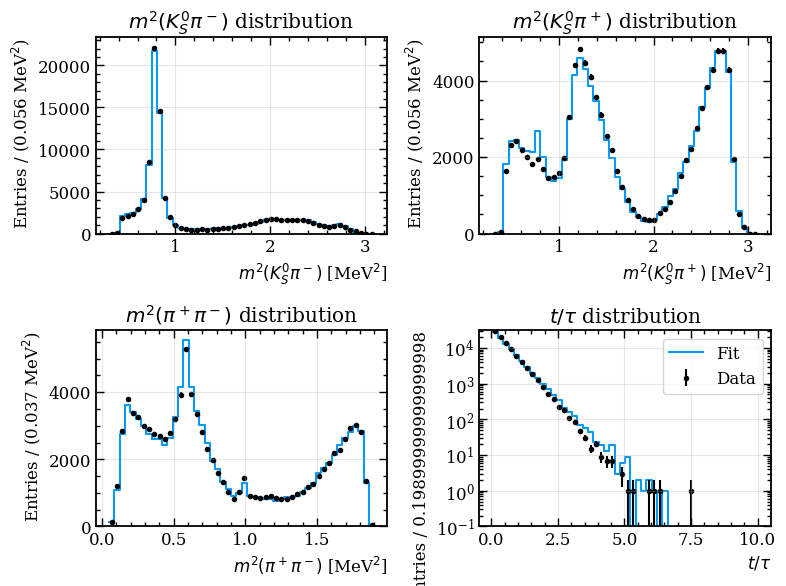

In [17]:
x_mix = atfi.const(0.2)
y_mix = atfi.const(0.2)
qoverp = atfi.complex(atfi.const(1.5), atfi.const(0.0))
def toymc_model_mix(x):
    return model_mix(x)(
        x_mix_par=x_mix,
        y_mix_par=y_mix,
        qoverp_re=atfi.real(qoverp),
        qoverp_im=atfi.imaginary(qoverp)
        )
toy_sample_mix = tft.run_toymc(
    toymc_model_mix, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)
fig, ax = plot_data_comparison_mix([toy_sample,toy_sample_mix], c_phsp)

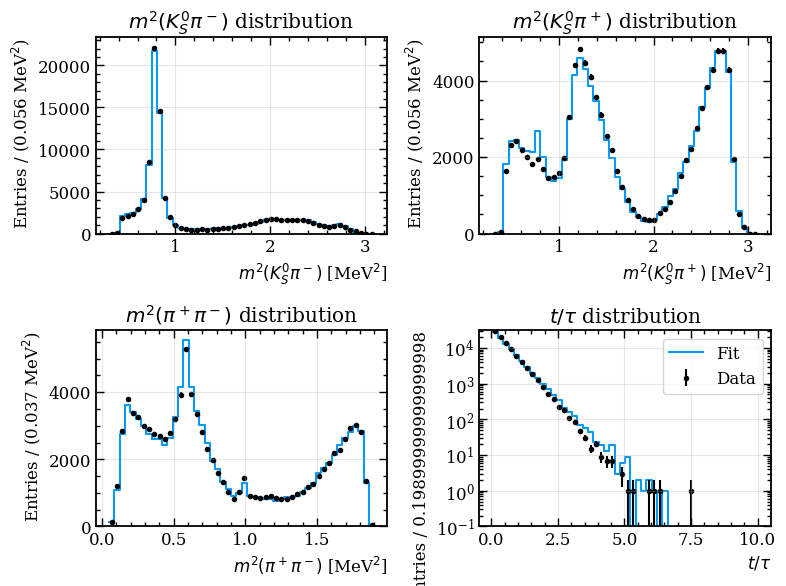

In [18]:
fig, ax = plot_data_comparison_mix([toy_sample,toy_sample_mix], c_phsp)

Effects of mixing and CPV become visible when large mixing parameters are used.

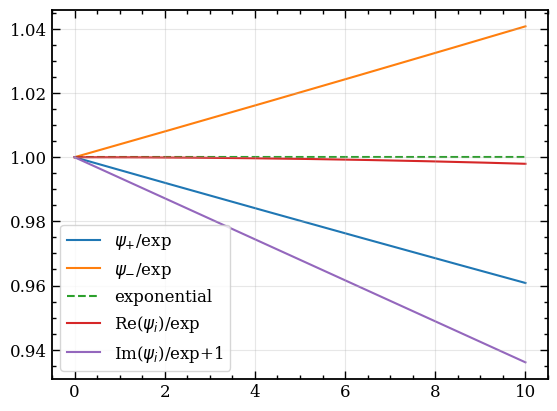

In [19]:
x_mix = atfi.const(0.004)
y_mix = atfi.const(0.0064)
t_pl = np.linspace(0,10,1000)
plt.plot( t_pl, atfm.psip(t_pl, x_mix, tdz)/np.exp(-t_pl/tdz), label=r'$\psi_{+}$/exp' )
plt.plot( t_pl, atfm.psim(t_pl, x_mix, tdz)/np.exp(-t_pl/tdz), label=r'$\psi_{-}$/exp' )
plt.plot( t_pl, np.ones(len(t_pl)), label='exponential', linestyle='dashed' )
plt.plot( t_pl, np.real(atfm.psii(t_pl, y_mix, tdz))/np.exp(-t_pl/tdz), label=r'Re($\psi_{i}$)/exp' )
plt.plot( t_pl, 1+np.imag(atfm.psii(t_pl, y_mix, tdz))/np.exp(-t_pl/tdz), label=r'Im($\psi_{i}$)/exp+1' )
#plt.yscale('log')
plt.legend()

## Likelihood

The Negative Log Likelihood

In [20]:
# TF graph for unbinned negalite log likelihood (the quantity to be minimised)
def nll(data, norm):
    data_model = model_mix(data)
    norm_model = model_mix(norm)

    @atfi.function
    def _nll(pars):
        return atfl.unbinned_nll(data_model(**pars), atfl.integral(norm_model(**pars)))

    return _nll

## Samples

The samples to fit

In [21]:
ntoys = 2500000
nnorm = 10*ntoys

In [22]:
x_mix = atfi.const(0.004)
y_mix = atfi.const(0.0064)
qoverp = atfi.complex(atfi.const(1.0), atfi.const(0.0))
def toymc_model_mix(x):
    return model_mix(x)(
        x_mix_par=x_mix,
        y_mix_par=y_mix,
        qoverp_re=atfi.real(qoverp),
        qoverp_im=atfi.imaginary(qoverp)
        )
toy_sample_mix = tft.run_toymc(
    toymc_model_mix, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)
print(toy_sample_mix)

  Updating maximum: 1e-20 -> 6700.115869652116. Starting over.
  Chunk 1, size=5527, total length=5527
  Chunk 2, size=5563, total length=11090
  Chunk 3, size=5559, total length=16649
  Chunk 4, size=5545, total length=22194
  Chunk 5, size=5628, total length=27822
  Chunk 6, size=5590, total length=33412
  Chunk 7, size=5467, total length=38879
  Chunk 8, size=5577, total length=44456
  Chunk 9, size=5502, total length=49958
  Chunk 10, size=5567, total length=55525
  Chunk 11, size=5592, total length=61117
  Chunk 12, size=5520, total length=66637
  Chunk 13, size=5496, total length=72133
  Chunk 14, size=5436, total length=77569
  Chunk 15, size=5479, total length=83048
  Chunk 16, size=5587, total length=88635
  Chunk 17, size=5600, total length=94235
  Chunk 18, size=5525, total length=99760
  Chunk 19, size=5593, total length=105353
  Chunk 20, size=5488, total length=110841
  Chunk 21, size=5546, total length=116387
  Chunk 22, size=5333, total length=121720
  Chunk 23, size=55

and to calculate the integrals

In [23]:
norm_sample = c_phsp.uniform_sample(nnorm)
print(norm_sample)

tf.Tensor(
[[0.61663157 1.83932293 1.41393514]
 [2.20789318 1.37222565 0.33035064]
 [0.76361064 2.43837809 0.30501777]
 ...
 [0.88006348 1.70601286 0.28014919]
 [1.68989184 1.5901382  0.90762672]
 [1.57852183 0.87147257 2.33115613]], shape=(11869175, 3), dtype=float64)


Beware that only approximately 1/2 of the events have been generated in the normalisation sample.

## Fit

We are now ready to run the fit. We define first the fit parameters:

In [24]:
pars = [
    tfo.FitParameter("x_mix_par", 0.004, -0.02, 0.02),
    tfo.FitParameter("y_mix_par", 0.006, -0.02, 0.02),
    tfo.FitParameter("qoverp_re", 1.0, -1.5, 1.5),
    tfo.FitParameter("qoverp_im", 0.0, -1.5, 1.5),
]
fixed_pars = ['qoverp_re','qoverp_im']
for p in pars:
    if p.name in fixed_pars:
        p.fix()

In [25]:
for p in pars:
    print(p.name, p.floating())

x_mix_par True
y_mix_par True
qoverp_re False
qoverp_im False


and run Minuit

In [26]:
# Run MINUIT minimisation of the neg. log likelihood
result = tfo.run_minuit(nll(toy_sample_mix, norm_sample), pars)
print(result)
cov = result['covariance'] if 'covariance' in result.keys() else None
if cov is None: print('COVARIANCE NOT VALID')

print(f"{result['time']/result['func_calls']} sec per function call")

fitted_pars = {p: atfi.const(v[0]) for p, v in result["params"].items()}

10 -2890194.1030311636 [0.004   0.00599]
20 -2890194.6886956193 [0.00256851 0.00657221]
30 -2890194.6886630794 [0.00257851 0.00657221]
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.89e+06                  │         Nfcn = 29, Ngrad = 2         │
│ EDM = 6.93e-07 (Goal: 0.0001)    │            time = 1.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└────────────────────────────

Define a function with the fitted model to calculate fit fractions and projections

In [27]:
def fitted_model(x):
    return model_mix(x)(**fitted_pars)

## Plotting

For plotting the results we generate a sample according to the model and we overlay it to the data

In [28]:
fitted_sample = tft.run_toymc(
    fitted_model, c_phsp, nnorm, maximum=1.0e-20, chunk=1000000, components=True
)

  Updating maximum: 1e-20 -> 6569.492155866299. Starting over.
  Chunk 1, size=5721, total length=5721
  Chunk 2, size=5809, total length=11530
  Chunk 3, size=5637, total length=17167
  Chunk 4, size=5588, total length=22755
  Chunk 5, size=5633, total length=28388
  Chunk 6, size=5702, total length=34090
  Chunk 7, size=5588, total length=39678
  Chunk 8, size=5666, total length=45344
  Chunk 9, size=5694, total length=51038
  Chunk 10, size=5811, total length=56849
  Chunk 11, size=5719, total length=62568
  Chunk 12, size=5695, total length=68263
  Chunk 13, size=5581, total length=73844
  Chunk 14, size=5698, total length=79542
  Chunk 15, size=5624, total length=85166
  Chunk 16, size=5709, total length=90875
  Chunk 17, size=5667, total length=96542
  Chunk 18, size=5629, total length=102171
  Chunk 19, size=5753, total length=107924
  Chunk 20, size=5593, total length=113517
  Chunk 21, size=5644, total length=119161
  Chunk 22, size=5567, total length=124728
  Chunk 23, size=5

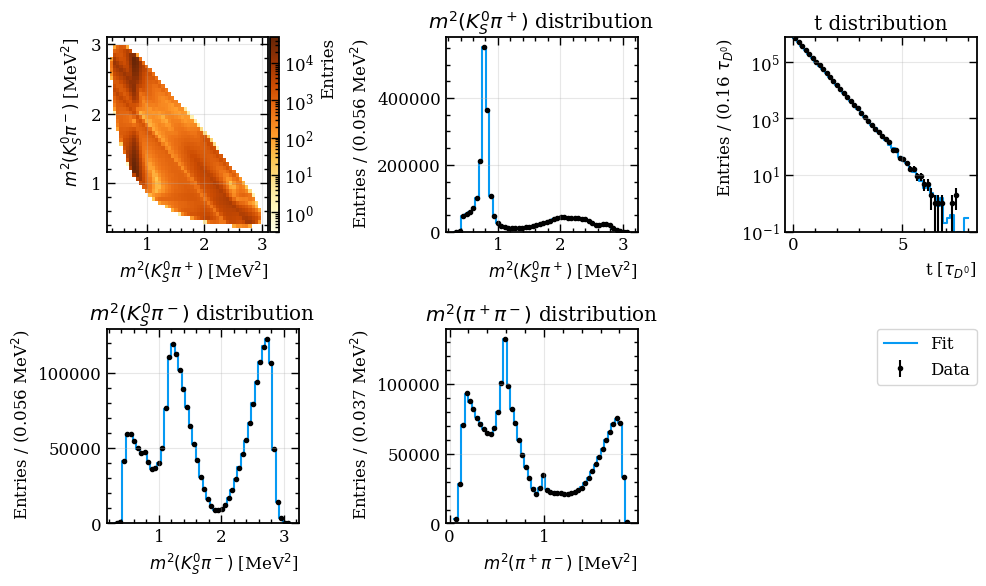

In [30]:
# Plot results
import matplotlib.pyplot as plt

tfp.set_lhcb_style(size=12, usetex=False)  # Adjust plotting style for LHCb papers
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))  # Single subplot on the figure

# Plot 1D histogram from the toy MC sample
tfp.plot_distr2d(
    toy_sample_mix[:, 0],
    toy_sample_mix[:, 1],
    bins=(50, 50),
    ranges=((0.3, 3.1), (0.3, 3.1)),
    fig=fig,
    ax=ax[0, 0],
    labels=(r"$m^2(K_S^0\pi^+)$", r"$m^2(K_S^0\pi^-)$"),
    units=("MeV$^2$", "MeV$^2$"),
    log=True,
)

tfp.plot_distr1d_comparison(
    toy_sample_mix[:, 0],
    fitted_sample[:, 0],
    #cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[0, 1],
    label=r"$m^2(K_S^0\pi^+)$",
    units="MeV$^2$",
    legend=False
)

tfp.plot_distr1d_comparison(
    toy_sample_mix[:, 1],
    fitted_sample[:, 1],
    #cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[1, 0],
    label=r"$m^2(K_S^0\pi^-)$",
    units="MeV$^2$",
    legend=False
)

tfp.plot_distr1d_comparison(
    toy_sample_mix[:, 2],
    fitted_sample[:, 2],
    #cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0., 8),
    ax=ax[0, 2],
    label=r"t",
    units=r"$\tau_{D^0}$",
    log=True,
    legend=False
)

tfp.plot_distr1d_comparison(
    c_phsp.phsp1.m2ac(c_phsp.data1(toy_sample_mix)),
    c_phsp.phsp1.m2ac(c_phsp.data1(fitted_sample)),
    #cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0.05, 1.9),
    ax=ax[1, 1],
    label=r"$m^2(\pi^+\pi^-)$",
    units="MeV$^2$",
    legend_ax=ax[1,2]
)

# Show the plot
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)